# Weak lensing – Notebook 30th January 2024 to ...

In [173]:
%matplotlib inline

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from scipy import ndimage, signal, stats, optimize

import astropy as ap
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93, ks93inv

import galsim

In [5]:
with open('../config.yml', 'r') as file:
    config_data = yaml.safe_load(file)

KTNG_DIR = os.path.expanduser(config_data['ktng_dir'])
TRECS_DIR = os.path.expanduser(config_data['trecs_dir'])
TRECS_FILE = config_data['trec_file']

REDSHIFTS = [0.506, 1.034, 1.532] # red shifts for the simulated convergence maps
FILENAMES = ['kappa13', 'kappa23', 'kappa30'] # corresponding filenames

## 2024-01-30

### Figures for the TITAN-TOSCA workshop

#### Illustration of shear and convergence
*Code inspired from https://github.com/CosmoStat/ShapeDeconv/blob/master/data/T-RECS/Generate%20Radio%20ground%20truth%20from%20T-RECS.ipynb*

Open T-RECS catalog:

In [8]:
catalog_sfg = ap.io.fits.open(os.path.join(TRECS_DIR, TRECS_FILE))
catdata_sfg = catalog_sfg[1].data

flux1400sfg = catdata_sfg['I1400'] # flux density at 1400 MHz (in Janskys)
sizesfg = catdata_sfg['size'] # angular size on the sky (in arcsec)
e1 = catdata_sfg['e1'] # first ellipticity
e2 = catdata_sfg['e2'] # second ellipticity

In [37]:
imgsize = 64
pixelscale = 1.5 # Size of pixel in arcsec on the sky. Helps sampling the images w.r.t. catalogues.
fft_bigsize = 81488  # Max size of support for Galsim (Caching the FFT)

Filter galaxies by size:

In [73]:
minpixsize = 10
maxpixsize = 20

filterobj = np.logical_and(sizesfg > minpixsize*pixelscale, sizesfg < maxpixsize*pixelscale)
listindexobj = np.where(filterobj == True)[0]
print(f"Number of selected galaxies = {len(listindexobj)}")

Number of selected galaxies = 80


Generate star-forming galaxies (T-RECS):

In [180]:
#idx_source = np.random.choice(listindexobj)
idx_source = 43980
fluxsource = flux1400sfg[idx_source]
e1gal = e1[idx_source]
e2gal = e2[idx_source]

In [181]:
def create_stamp(imgsize, pixelscale):
    stamp = galsim.ImageF(imgsize, imgsize, scale=pixelscale)
    stamp = stamp[galsim.BoundsI(1, imgsize, 1, imgsize)]
    return stamp

In [182]:
big_fft_params = galsim.GSParams(maximum_fft_size=fft_bigsize)
gauss_gal = galsim.Gaussian(fwhm=sizesfg[idx_source], flux=fluxsource)
gal = galsim.Exponential(half_light_radius=gauss_gal.half_light_radius, flux=fluxsource, gsparams=big_fft_params)
ellipticity = galsim.Shear(e1=e1gal, e2=e2gal)
gal = gal.shear(ellipticity)
stamp = create_stamp(imgsize, pixelscale)
galimg = gal.drawImage(stamp, scale=pixelscale)

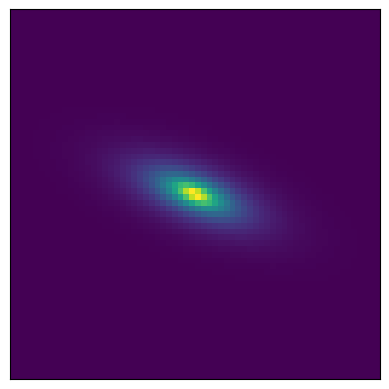

In [185]:
plt.figure()
plt.imshow(galimg.array)
plt.xticks([])
plt.yticks([])
plt.show()

Apply convergence:

In [184]:
convergence = 2
gal_conv = gal.dilate(convergence)
stamp = create_stamp(imgsize, pixelscale)
galimg_conv = gal_conv.drawImage(stamp, scale=pixelscale)

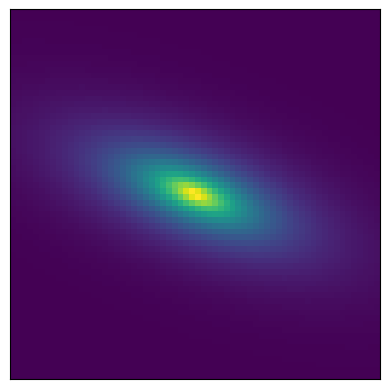

In [186]:
plt.figure()
plt.imshow(galimg_conv.array)
plt.xticks([])
plt.yticks([])
plt.show()

Apply shear:

In [211]:
shear1, shear2 = 0.1, -0.3
shear = galsim.Shear(e1=shear1, e2=shear2)
gal_conv_shear = gal_conv.shear(shear)
stamp = create_stamp(imgsize, pixelscale)
galimg_conv_shear = gal_conv_shear.drawImage(stamp, scale=pixelscale)

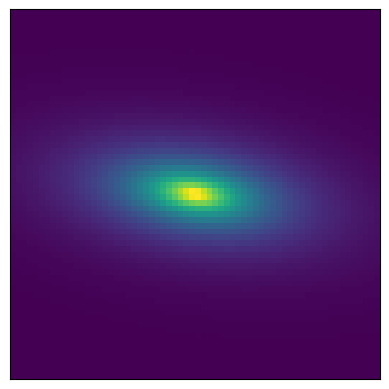

In [212]:
plt.figure()
plt.imshow(galimg_conv_shear.array)
plt.xticks([])
plt.yticks([])
plt.show()